<h1><center><font size="6">House Price EDA and Prediction</font></center></h1>


<h2><center><font size="4">2019 2nd ML month with KaKR</font></center></h2>
<h3><center><font size="2">캐글 코리아와 함께하는 2nd ML 대회 - House Price Prediction</font></center></h3>

<br>

# **<a id='0'>Content</a>**

- <a href='#1'>Introduction</a>  
- <a href='#2'>Prepare data analysis</a>  
- <a href='#3'>Data exploration</a>  
    - <a href='#31'>Check the data</a>  
    - <a href='#32'>Density plots of features</a>   
    - <a href='#33'>Features correlations</a>   
    - <a href='#34'>Duplicate values</a>   
- <a href='#4'>Feature Engineering</a>
- <a href='#5'>Model</a>
    - <a href='#51'>Modeling</a>
    - <a href='#52'>Evalution</a>
    - <a href='#53'>Submission</a>
- <a href='#6'>Feature Engineering2</a>
- <a href='#7'>Model</a>
- <a href='#8'>Submission</a>

# **<a id='1'>Introduction</a>**


#### **Competition background**
내 집 마련의 꿈은 누구나 가지고 있습니다. 하지만 집의 가격은 누구나 알고 있지는 않죠. 집의 가격은 주거 공간의 면적, 위치, 경관, 건물의 연식 등 여러 가지 복잡한 요인의 조합에 의해 결정됩니다. 이번에 분석하실 데이터는 20개의 변수를 가지고 있으며, 어떤 조건을 가진 집의 가격이 높고 낮은지를 예측하는 모델을 만드는 것을 목표로 합니다. 이번 대회는 리더보드 점수뿐만 아니라 캐글의 공유 정신의 기본인 커널 작성을 장려하는 목표를 가지고 있습니다.

#### **Evaluation**
RMSE : Root Mean Squared Error

#### **Timeline**
'19.03.11 ~ '19.04.22

#### **Data**
train.csv, test.csv, sample_submission.csv

# **<a id='2'>Prepare data analysis</a>**

## Load Package

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.linear_model import LinearRegression
import statsmodels

%matplotlib inline
import cloudpickle

## Load data   

데이터를 로드합니다.
Let's check what data files are available.

In [2]:
%%time
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

CPU times: user 64 ms, sys: 20 ms, total: 84 ms
Wall time: 109 ms


데이터가 어떤지 확인해 봅시다.

# **<a id='3'>Data Exploration</a>**

## <a id='31'>Check the data</a>

In [3]:
train.shape, test.shape

((15035, 21), (6468, 20))

train data가 test data에 비해 약 2.3배 정도 많은 것을 알 수 있습니다.

In [4]:
train.columns, test.columns

(Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
        'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
        'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
        'lat', 'long', 'sqft_living15', 'sqft_lot15'],
       dtype='object'),
 Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
        'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
        'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
        'sqft_living15', 'sqft_lot15'],
       dtype='object'))

In [5]:
print(set(train.columns)-set(test.columns))
print(set(test.columns)-set(train.columns))

{'price'}
set()


컬럼의 경우 종속변수인 'price'를 제외하고 20개가 동일합니다.

Let's glimpse train and test data!

In [6]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [7]:
test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [8]:
import sklearn.ensemble

#### **Train contains:  **

* **id** (string);  
* **price**;  (float)
* **8** numerical variables
* **named**
    - sqft_living : 주거 공간의 평방 피트(면적)
    - sqft_lot : 부지의 평방 피트(면적)
    - sqft_above : 지하실을 제외한 평방 피트(면적)
    - sqft_basement : 지하실의 평방 피트(면적)
    - lat : 위도
    - long : 경도
    - sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
    - sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
* **11** categorical variables, named from **var_0** to **var_199**
* **named**
    - date : 집을 구매한 날짜
    - bedrooms : 침실의 수
    - bathrooms : 침실 개수 당 화장실의 수(화장실의 수 / 침실의 수 )
    - floors : 집의 층 수
    - waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
    - view : 집이 얼마나 좋아 보이는지의 정도
    - condition : 집의 전반적인 상태
    - grade : King County grading 시스템 기준으로 매긴 집의 등급
    - yr_built : 지어진 년도
    - yr_renovated : 집을 재건축한 년도
    - zipcode : 우편번호

#### **Test contains:  **

* **id** (string);  
* **8** numerical variables
* **named**
    - Same as train
* **11** categorical variables, named from **var_0** to **var_199**
* **named**
    - Same as train


데이터의 구조를 확인했습니다.

이제 데이터를 더 느껴봅시다. 먼저 결측값을 확인합니다.

train data를 먼저 보겠습니다.

In [9]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    types = [str(data[i].dtype) for i in data.columns]
    
    df = pd.DataFrame({'Total':total, 'Precent':percent, 'Types':types})
    
    return(sp.transpose(df))

In [10]:
%%time
missing_data(train)

CPU times: user 40 ms, sys: 12 ms, total: 52 ms
Wall time: 52 ms


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
Total,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Precent,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Types,int64,object,float64,int64,float64,int64,int64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int64,int64


In [11]:
%%time
missing_data(test)

CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 22.3 ms


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
Total,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Precent,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Types,int64,object,int64,float64,int64,int64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int64,int64


결측값이 존재하지 않습니다. describe를 통해 대략적으로 살펴 보겠습니다.

In [12]:
%%time
train.describe()

CPU times: user 80 ms, sys: 0 ns, total: 80 ms
Wall time: 78.7 ms


,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,15035.000000,1.503500e+04,15035.000000,15035.000000,15035.000000,1.503500e+04,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000
mean,7517.000000,5.406827e+05,3.369139,2.115065,2083.790223,1.529697e+04,1.498071,0.007117,0.234253,3.406651,7.660725,1794.158164,289.632059,1971.100432,83.798936,98078.031726,47.560721,-122.213677,1992.754772,12823.884935
std,4340.374984,3.715247e+05,0.902721,0.767519,922.134087,4.261282e+04,0.538522,0.084063,0.763376,0.646505,1.179803,831.738609,440.663284,29.407612,400.398498,53.297815,0.138164,0.141294,691.456442,27736.259787
min,0.000000,7.800000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3758.500000,3.220000e+05,3.000000,1.750000,1430.000000,5.027500e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.472700,-122.328000,1490.000000,5100.000000
50%,7517.000000,4.500000e+05,3.000000,2.250000,1910.000000,7.620000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1570.000000,0.000000,1975.000000,0.000000,98065.000000,47.571900,-122.231000,1850.000000,7610.000000
75%,11275.500000,6.450000e+05,4.000000,2.500000,2560.000000,1.069550e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2230.000000,550.000000,1997.000000,0.000000,98117.000000,47.678300,-122.126000,2360.000000,10076.000000
max,15034.000000,7.700000e+06,10.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4130.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [13]:
%%time
test.describe()

CPU times: user 48 ms, sys: 4 ms, total: 52 ms
Wall time: 52.3 ms


,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,6468.000000,6468.00000,6468.000000,6468.000000,6.468000e+03,6468.000000,6468.000000,6468.000000,6468.000000,6468.000000,6468.000000,6468.000000,6468.000000,6468.000000,6468.000000,6468.000000,6468.000000,6468.000000,6468.000000
mean,18268.500000,3.37786,2.118313,2075.981293,1.469916e+04,1.488327,0.008658,0.235467,3.416821,7.655535,1779.556277,296.425015,1970.949443,86.933983,98077.587044,47.558726,-122.214039,1974.429654,12659.800402
std,1867.295103,0.99064,0.775851,910.613001,3.870428e+04,0.544007,0.092652,0.773616,0.658267,1.161900,820.834051,447.218709,29.292377,407.210870,53.936590,0.139659,0.139766,671.597761,26380.422371
min,15035.000000,0.00000,0.000000,370.000000,6.810000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,0.000000,98001.000000,47.159300,-122.512000,460.000000,748.000000
25%,16651.750000,3.00000,1.750000,1420.000000,5.084000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1952.000000,0.000000,98032.000000,47.467175,-122.327000,1480.000000,5100.000000
50%,18268.500000,3.00000,2.250000,1920.000000,7.607000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1550.000000,0.000000,1975.000000,0.000000,98065.000000,47.572150,-122.229000,1820.000000,7664.500000
75%,19885.250000,4.00000,2.500000,2520.000000,1.066425e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2190.000000,590.000000,1997.000000,0.000000,98118.000000,47.677400,-122.123000,2370.000000,10125.000000
max,21502.000000,33.00000,6.750000,9640.000000,1.164794e+06,3.500000,1.000000,4.000000,5.000000,13.000000,8020.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.364000,5610.000000,438213.000000


우리는 다음과 같은 사항을 관찰 할 수 있습니다.
* price 단위와 표준편차가 큽니다.
* categorical 변수들은 skew되어 있는 변수들이 많습니다.
* categorical 변수의 데이터의 경우 sparse한 인스턴스들에 대해 train data에는 존재하지만, test data에는 존재하지 않는 혹은 그 역의 경우가 존재할 수 있습니다. 인지하고 있는게 좋을 것 같습니다.
* 위도, 경도의 표준편차는 작습니다.
* scale이 제각각인 경우가 많습니다. 선형모델 혹은 신경망 모델을 사용한다면 normalization & scaling을 통해 데이터의 변환이 필요해 보입니다. 

그림을 통해 자세히 살펴보는 게 좋을 것 같습니다.

## <a id='32'>Density plots of features</a>   

변수들에 대한 분포를 확인해 봅시다.

먼저 target variable인 price를 살펴봅니다.

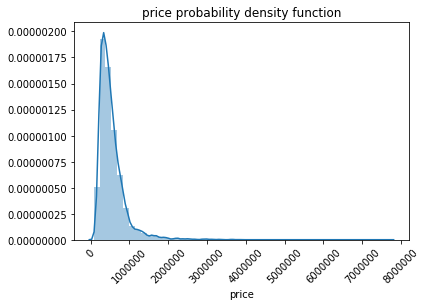

In [14]:
sns.distplot(train['price']).set_title('price probability density function')
plt.xticks(rotation=45)
plt.show()

target variable인 price가 왼쪽으로 skew되어 있습니다.

In [15]:
train['price'].skew(), train['price'].kurt()

(4.290252396939529, 40.15491919350329)

skewness와 kurtosis 둘 다 큰 수치가 나타납니다.

정규분포의 경우 skewness=0, kurtosis=3 입니다. price의 경우 오른쪽 꼬리가 길며, 봉우리가 정규분포보다 높다는 것을 나타냅니다.

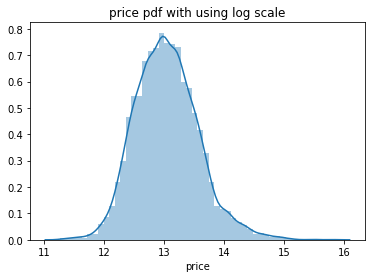

In [16]:
sns.distplot(sp.log1p(train['price'])).set_title('price pdf with using log scale')
plt.show()

log scale을 취하여 정규화를 시켜줍니다.

In [17]:
sp.log1p(train['price']).skew(), sp.log1p(train['price']).kurt()

(0.4330991387067915, 0.7316049825519855)

두 수치 모두 안정적으로 0에 가까워졌고, 정규분포에 가까워졌음을 나타냅니다.

반응변수가 정규분포를 따르는 것이 좋을까요?

회귀모형의 해석이 유의미 하기 위해서는 여러가지 가정을 만족해야 합니다.

보편적으로, 4가지 가정을 주로 확인합니다.
* 독립성
* 선형성
* 등분산성
* 정규성

정규성을 확인하는 방법은 3가지 정도가 있으나, 제 주관적 해석이 중요한 qq plot를 이용하겠습니다.

또한 반응변수가 정규분포를 따르면 잔차의 정규성을 만족시키기에 유리하므로 정규화를 시켜주겠습니다.

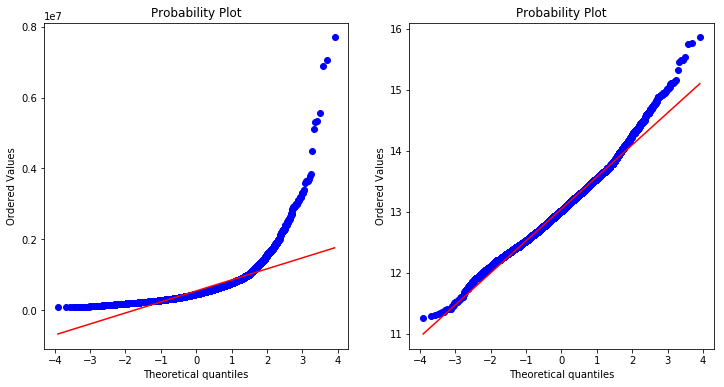

In [18]:
f, axes = plt.subplots(1, 2, figsize=(12, 6))
sp.stats.probplot(train['price'], plot=axes[0])
sp.stats.probplot(sp.log1p(train['price']), plot=axes[1])
plt.show()

종속변수에 대해 log를 취해주면 잔차의 정규성가정을 어느정도 만족시킬 수 있을 것이라고 생각하기 때문에, 로그를 취해줍니다.

In [19]:
train['price'] = sp.log1p(train['price'])

이제 설명변수들에 대해서 살펴 보겠습니다.

연속형 변수, Continuous variable에 대해 먼저 보겠습니다.

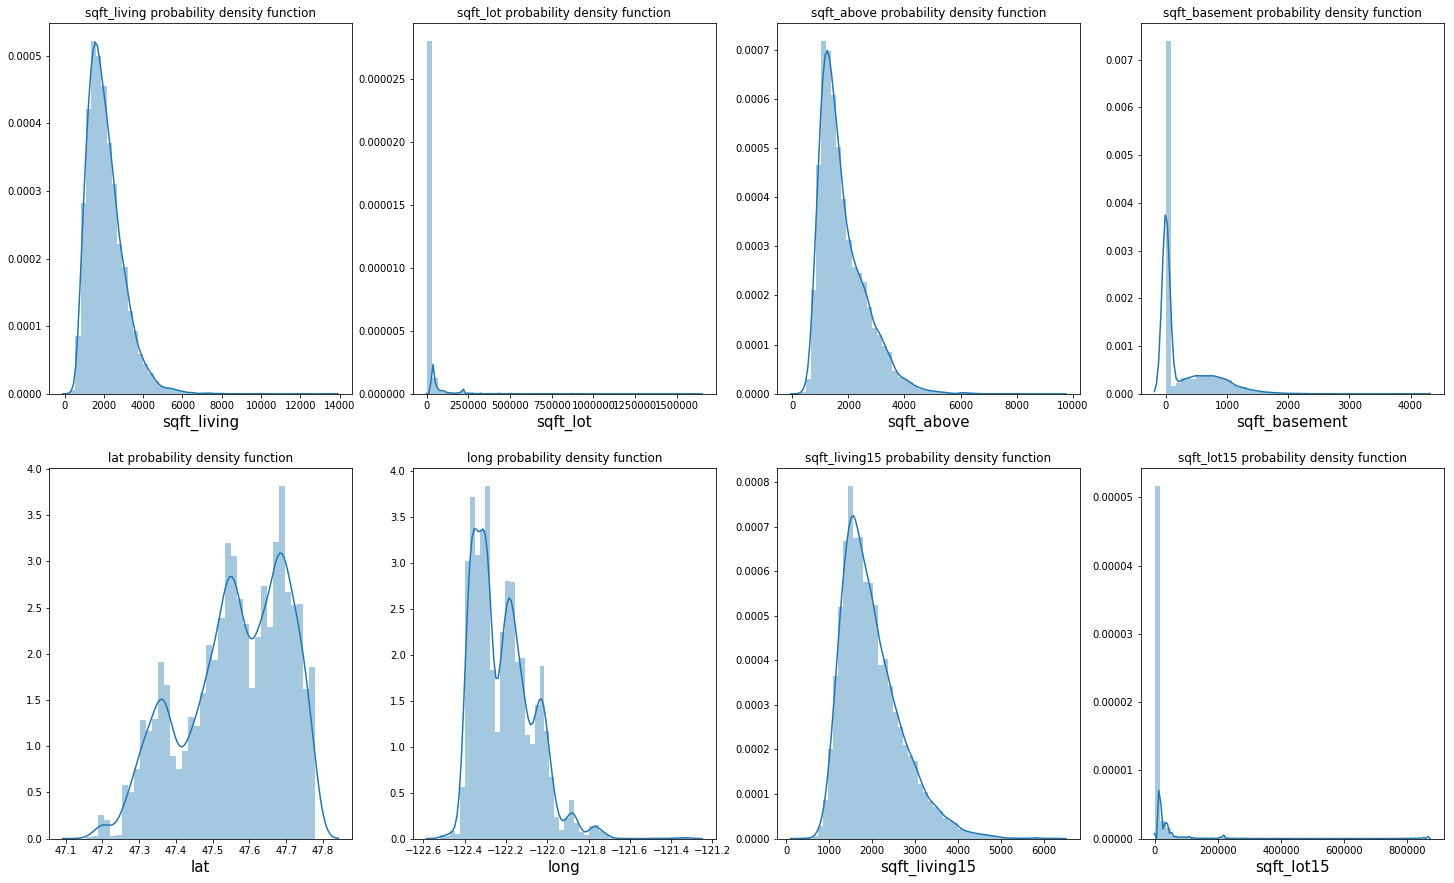

In [20]:
features = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
nrow=2; ncol=4
f, axes = plt.subplots(nrow, ncol, figsize=(25,15))
for idx, feature in enumerate(features):
    plt.subplot(nrow, ncol,idx+1)
    sns.distplot(train[feature]).set_title(str(feature) + ' probability density function')
    plt.xlabel(feature, fontsize=15)
plt.show()

skewess한 경우가 많습니다. 처리를 어떻게 해주는 것이 좋을까요?

정규화, 다항식으로의 변환 등의 처리를 해줄 수 있지만 독립성을 보존하기 위해 지금은 그대로 유지하겠습니다.

Categorical variable 변수들은 어떨까요?

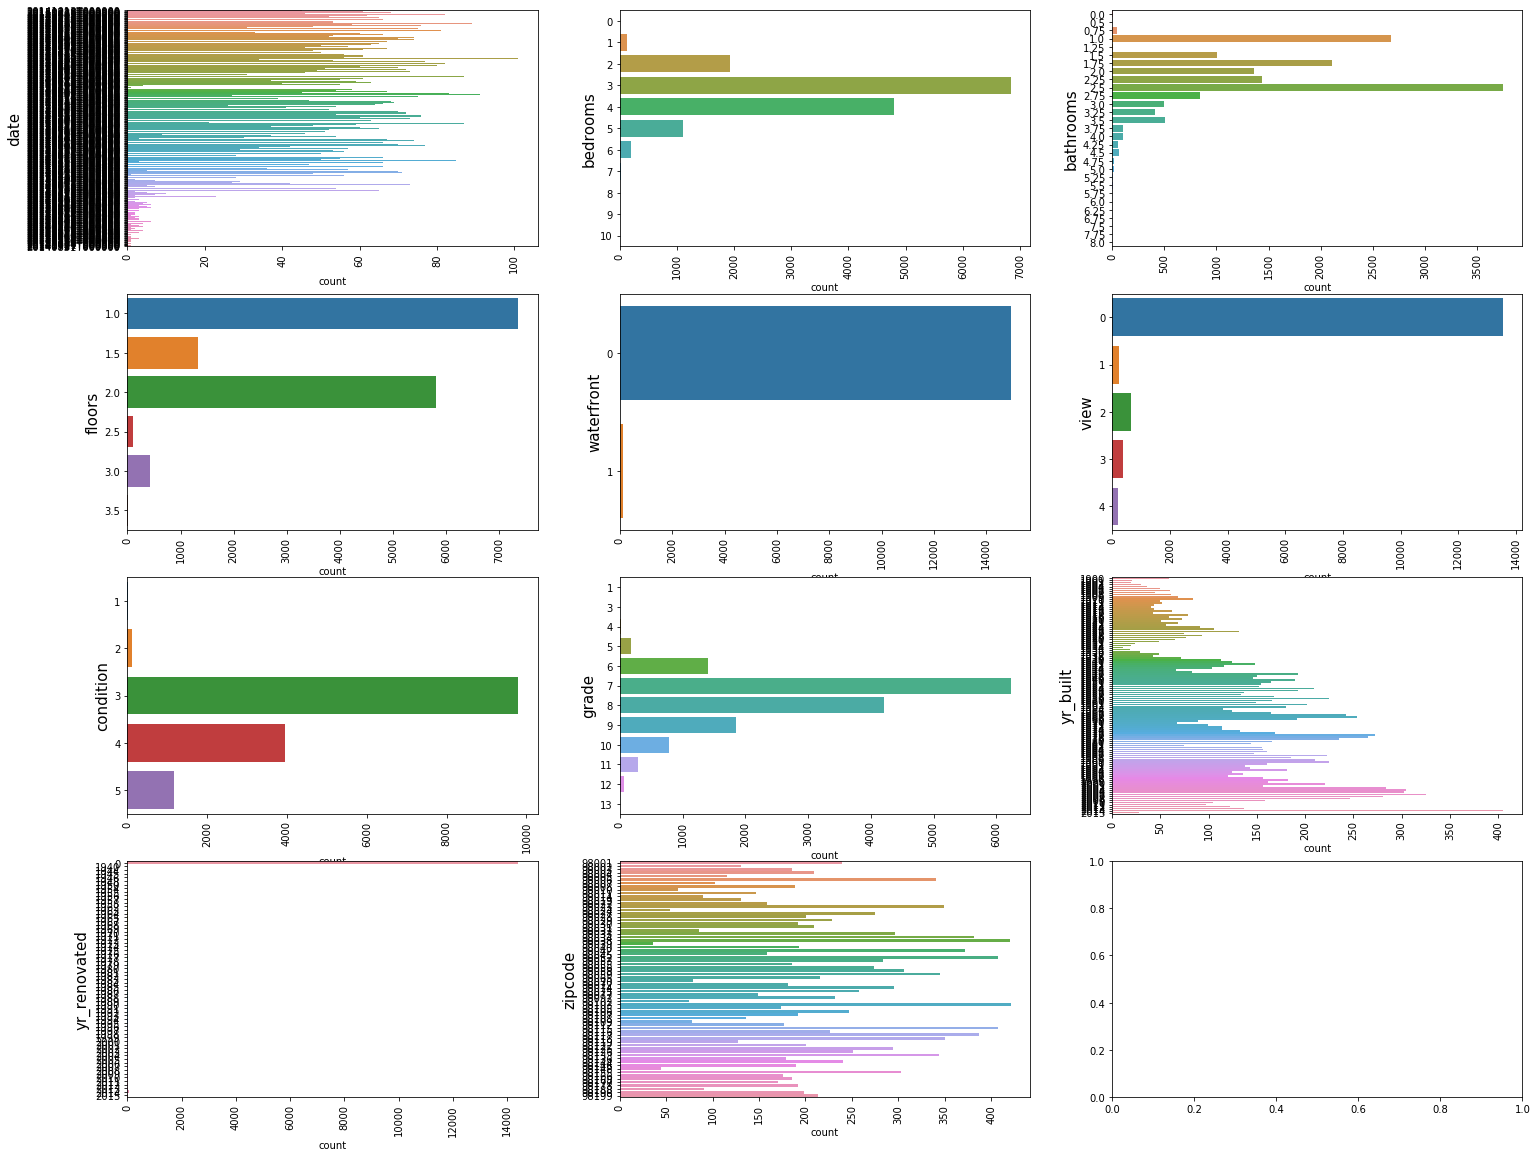

In [21]:
features = ['date', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade', 'yr_built', 'yr_renovated', 'zipcode']
nrow=4; ncol=3
f, axes = plt.subplots(nrow, ncol, figsize=(25,20))
for idx, feature in enumerate(features):
    plt.subplot(nrow, ncol,idx+1)
    sns.countplot(data=train, y=feature)
    plt.ylabel(feature, fontsize=15)
    plt.xticks(rotation=90)
plt.show()

데이터가 매우 많은 것은 아니므로, 단순하게 모두 count해보았습니다. 확인 할 수 있는 내용으로는

1. sparse한 변수가 많습니다.
2. 또한 date, yr_built, zipcode 등은 뒷부분에서 더미변수화 할 때 차원이 너무 커지므로 적절한 작업을 해줘야 합니다.
3. grade같은 예쁜 형태의 변수도 있는 것을 볼 수 있고, 다범주인 경우가 많아 이상치 혹은 테스트 데이터와 동일한 범주를 갖지 않을 수도 있다는 점을 알 수 있습니다.

이제 변수와 변수간의 관계를 살펴보겠습니다.

## <a id='33'>Features correlations</a>   

연속형 변수, Continuous variable에 대해 산점도를 그려 보겠습니다.

상관분석을 통한 상관계수를 보는 방법도 좋지만, 상관계수가 변수간의 관계에 대해 모든 것을 보여주지는 못하므로 산점도를 그리겠습니다.(price와 continous variabe에 대한 산점도 입니다.)

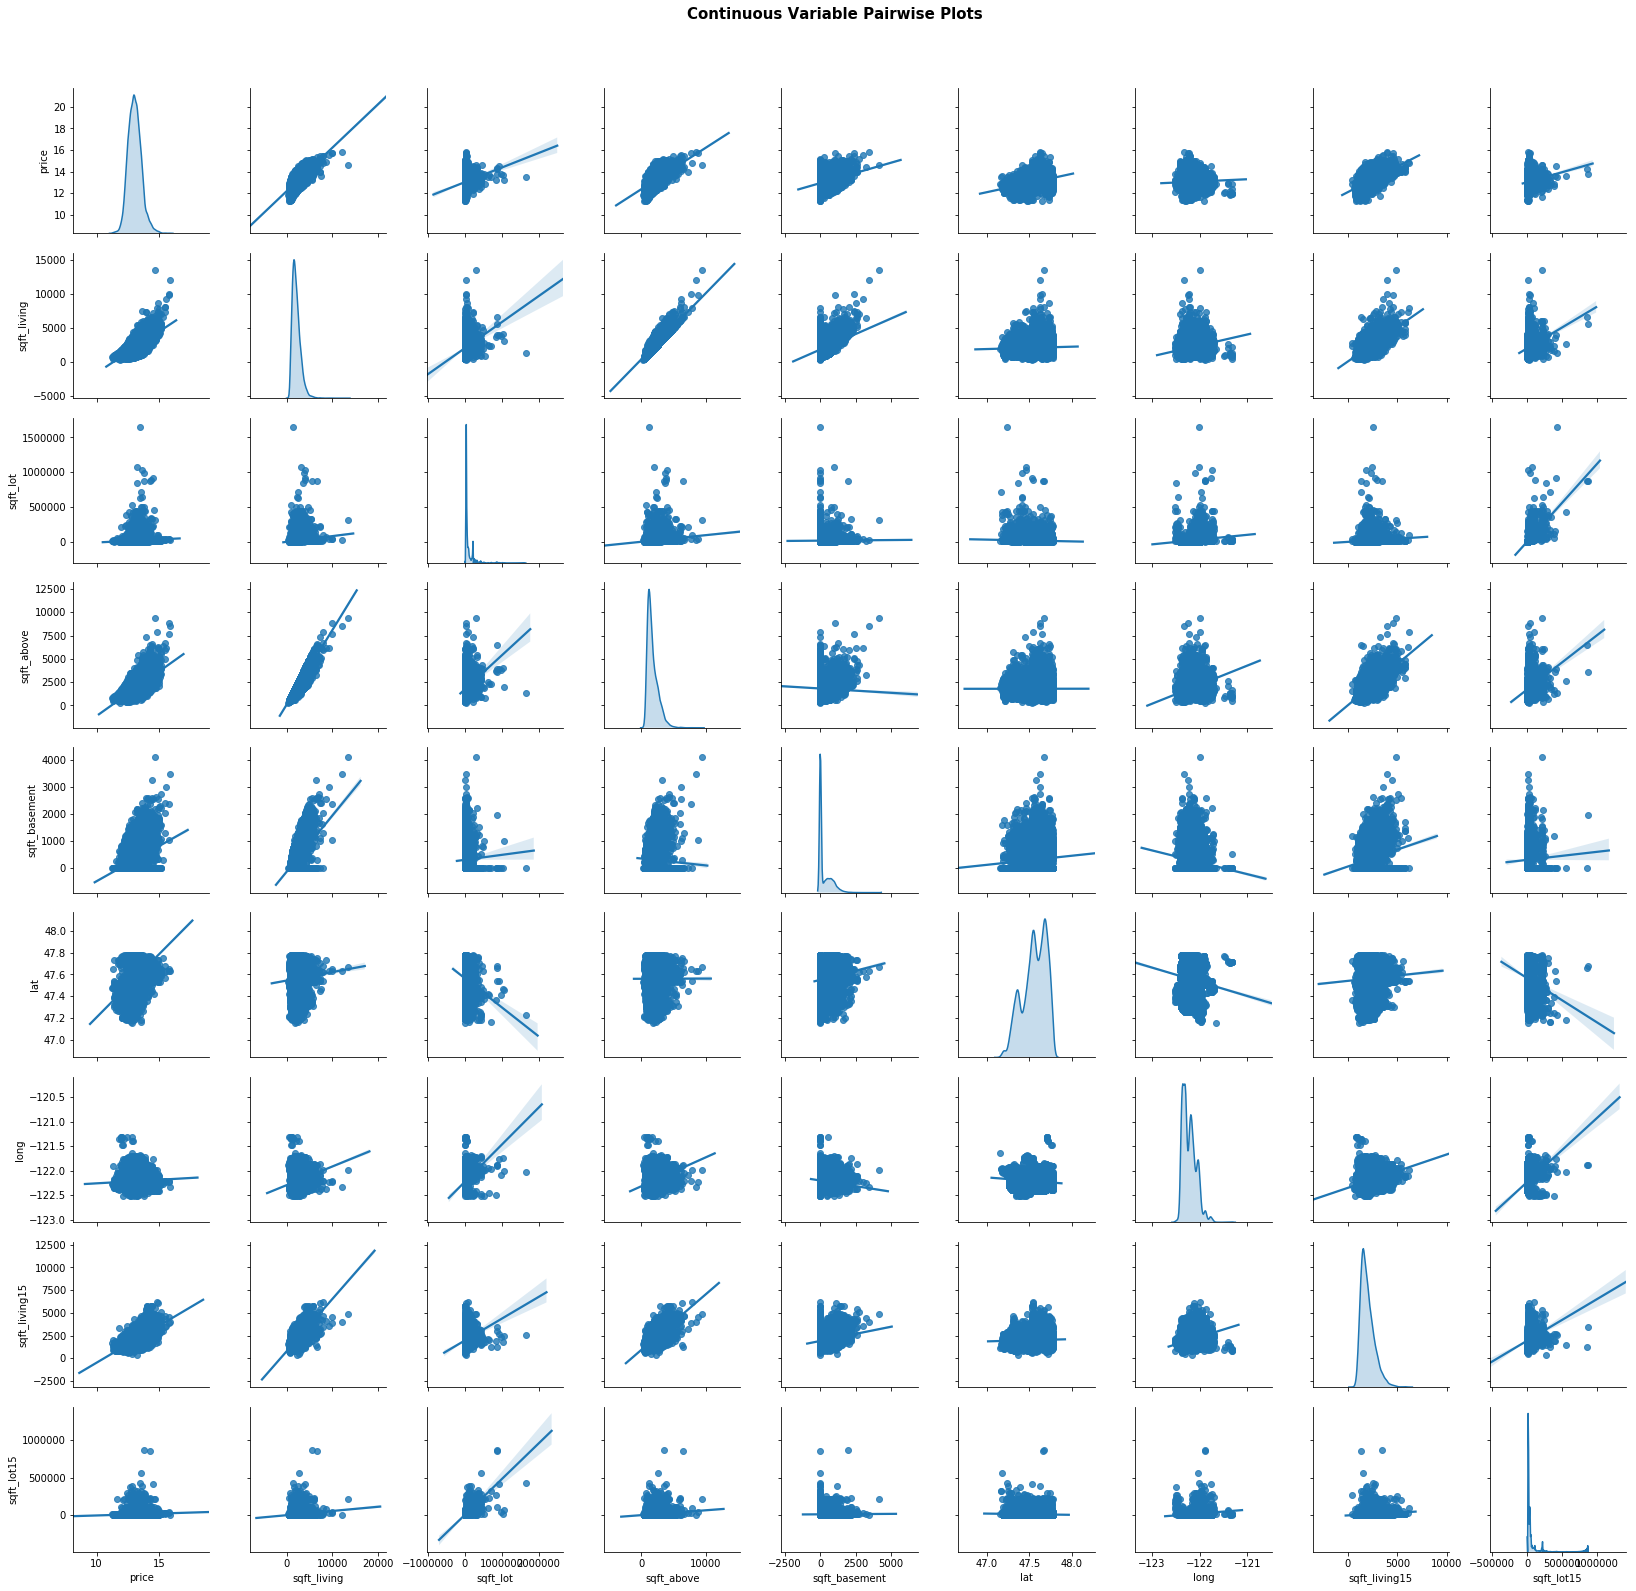

In [22]:
features = ['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
pp = sns.pairplot(train[features], 
                  diag_kws=dict(shade=True), # "diag" adjusts/tunes the diagonal plots
                  diag_kind="kde", # use "kde" for diagonal plots
                  kind="reg") # <== 😀 linear regression to the scatter plots

fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
fig.suptitle('Continuous Variable Pairwise Plots', fontsize=15, fontweight='bold')
plt.show()

흥미롭습니다. 종속변수와 독립변수간에 선형성을 띄는 그림이 많이 보입니다.

또한 독립변수 간에 선형성이 있는 변수들이 있는데, 다중공선성 혹은 과대, 과소추정 될 여지가 있으므로 후에 검사를 통해 확인해 보겠습니다.

조금 직관적으로 살펴보기 위해 상관계수 행렬을 보겠습니다.

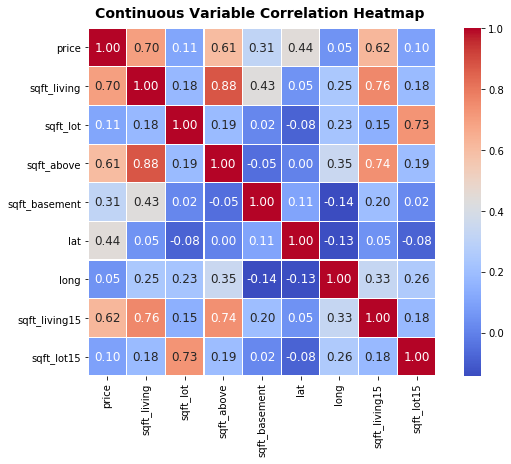

In [23]:
corr = train[features].corr()
fig, (ax) = plt.subplots(1, 1, figsize=(10,6))

hm = sns.heatmap(corr, 
                 ax=ax,           # Axes in which to draw the plot, otherwise use the currently-active Axes.
                 cmap="coolwarm", # Color Map.
                 square=True,    # If True, set the Axes aspect to “equal” so each cell will be square-shaped.
                 annot=True, 
                 fmt='.2f',       # String formatting code to use when adding annotations.
                 annot_kws={"size": 12},
                 linewidths=.05)

fig.subplots_adjust(top=0.93)
fig.suptitle('Continuous Variable Correlation Heatmap', 
              fontsize=14, 
              fontweight='bold')
plt.show()

직관적으로 변수들의 상관성을 볼수 있습니다.

이제 범주형 변수를 살펴 보겠습니다.

위에서 많은 범주를 가지고 있는 변수들에 대해 범주를 합쳐 줄여주겠습니다.

In [24]:
train['date'] = train['date'].apply(lambda x: str(x)[:6])
train['yr_built'] = train['yr_built'].apply(lambda x: str(x)[:3])
train['yr_renovated'] = train['yr_renovated'].apply(lambda x: str(x)[:3])
train['zipcode'] = train['zipcode'].apply(lambda x: str(x)[:4])

구매 날짜, 건축 년도, 재건축 년도는 단순하게 슬라이싱 하여 범주를 줄여주었습니다.

우편번호의 경우 미국의 우편체계를 모르지만, 편의를 위해 단순 슬라이싱을 통해 범주를 줄여주었습니다.

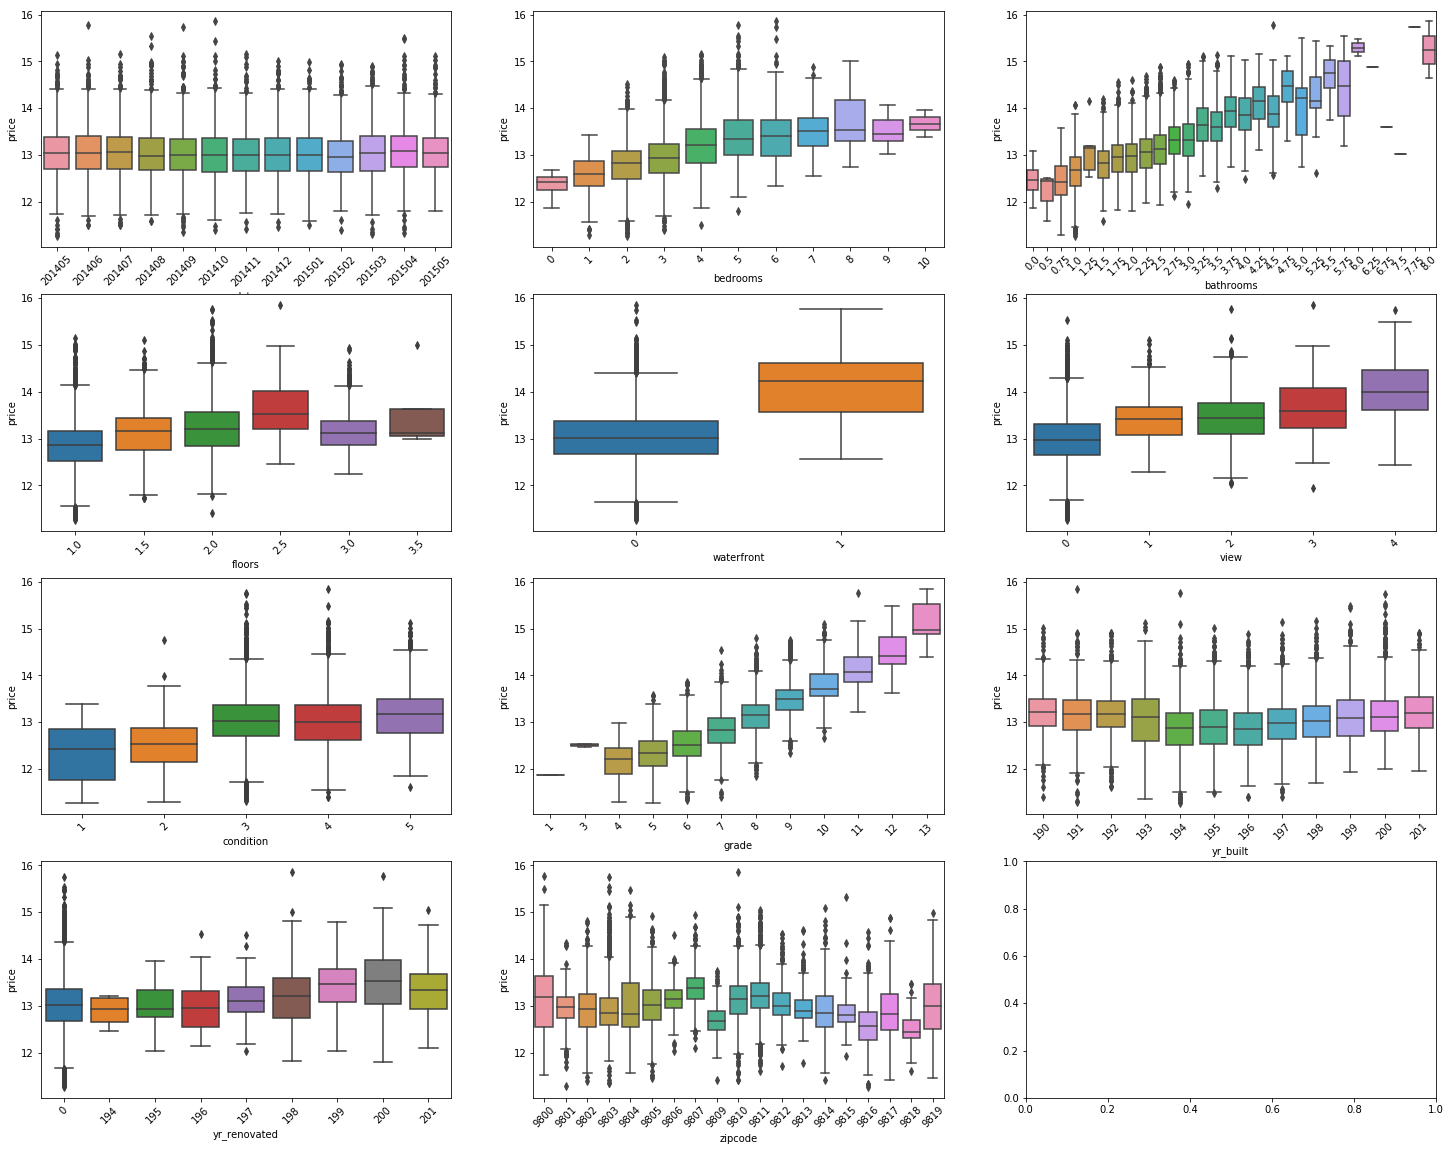

In [25]:
features = ['date', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade', 'yr_built', 'yr_renovated', 'zipcode']
nrow=4; ncol=3
f, axes = plt.subplots(nrow, ncol, figsize=(25, 20))
for idx, feature in enumerate(features):
    plt.subplot(nrow, ncol,idx+1)
    sns.boxplot(data=train, x=feature, y='price') # violinplot과 비슷
    ax.set_xlabel(feature, size=12, alpha=0.8)
    ax.set_ylabel('Price', size=12, alpha=0.8)
    plt.xticks(rotation=45)
plt.show()

Categorical Variable 경우에도 확실하게 변수에 따라서 가격이 증가, 감소하거나 변화가 없는 경우가 보입니다. 혹은 이상값들로 추정되는 값들도 보입니다.

모든 변수의 상관관계를 살펴 보겠습니다. 범주형변수의 경우 피어슨의 상관계수의 경우 연속된 자료에 대한 모수적인 방법이므로 적합하지 않습니다.

스피어만 상관계수인 순위 상관 척도를 사용하므로써 범주형 변수에 대한 상관관계를 구해보겠습니다.

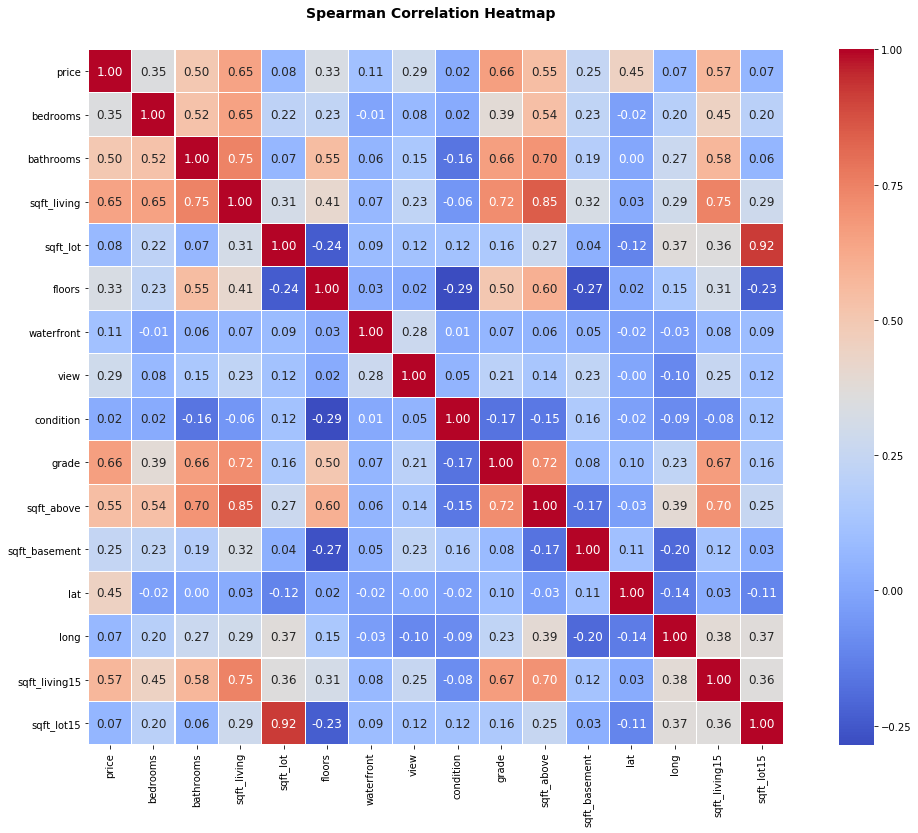

In [26]:
corr = train.drop(columns='id').corr(method='spearman')
fig, axes = plt.subplots(1, 1, figsize=(20,12))

hm = sns.heatmap(corr, 
                 ax=axes,           # Axes in which to draw the plot, otherwise use the currently-active Axes.
                 cmap="coolwarm", # Color Map.
                 square=True,    # If True, set the Axes aspect to “equal” so each cell will be square-shaped.
                 annot=True, 
                 fmt='.2f',       # String formatting code to use when adding annotations.
                 annot_kws={"size": 12},
                 linewidths=.05)

fig.subplots_adjust(top=0.93)
fig.suptitle('Spearman Correlation Heatmap', 
              fontsize=14, 
              fontweight='bold')
plt.show()

최고 0.92의 상관계수를 가진 변수들도 있습니다. 음의상관계수는 최하점이 -0.3정도 되는 것을 볼 수 있습니다.

대체적으로 price와 음의 상관관계를 가지는 변수는 없는 것으로 보입니다.

이제 Duplicate value에 대해서 탐색해보겠습니다.

## <a id='34'>Duplicate values</a>

In [27]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
train['price'] = sp.log1p(train['price'])

In [28]:
%%time
features = train.columns
unique_max_train = []
unique_max_test = []
for feature in features:
    if feature == 'price':
        values = train[feature].value_counts()
        unique_max_train.append([feature, values.max(), values.idxmax()])
    else:
        values = train[feature].value_counts()
        unique_max_train.append([feature, values.max(), values.idxmax()])
        values = test[feature].value_counts()
        unique_max_test.append([feature, values.max(), values.idxmax()])

CPU times: user 48 ms, sys: 0 ns, total: 48 ms
Wall time: 47 ms


In [29]:
sp.transpose((pd.DataFrame(unique_max_train, columns=['Feature', 'Max duplicates', 'Value'])).sort_values(by = 'Max duplicates', ascending=False))

,8,15,9,10,13,7,3,11,4,16,14,20,6,12,19,2,1,5,18,17,0
Feature,waterfront,yr_renovated,view,condition,sqft_basement,floors,bedrooms,grade,bathrooms,zipcode,yr_built,sqft_lot15,sqft_lot,sqft_above,sqft_living15,price,date,sqft_living,long,lat,id
Max duplicates,14928,14404,13548,9793,9143,7361,6835,6228,3748,421,405,297,256,145,142,123,101,98,84,14,1
Value,0,0,0,3,0,1,3,7,2.5,98103,2014,5000,5000,1300,1540,13.017,20140623T000000,1660,-122.29,47.5491,2047


In [30]:
sp.transpose((pd.DataFrame(unique_max_test, columns=['Feature', 'Max duplicates', 'Value'])).sort_values(by = 'Max duplicates', ascending=False))

,7,14,8,9,12,6,2,10,3,15,13,19,5,11,18,4,1,17,16,0
Feature,waterfront,yr_renovated,view,condition,sqft_basement,floors,bedrooms,grade,bathrooms,zipcode,yr_built,sqft_lot15,sqft_lot,sqft_above,sqft_living15,sqft_living,date,long,lat,id
Max duplicates,6412,6186,5837,4168,3913,3251,2929,2701,1616,179,153,129,101,71,62,48,47,38,8,1
Value,0,0,0,3,0,1,3,7,2.5,98103,2014,5000,5000,1010,1440,1300,20140625T000000,-122.361,47.6914,18431


중복 값들이 train data와 test data가 거의 비슷합니다. 데이터의 구조가 흡사하다는 생각이 드는군요.

이러한 흥미로운 패턴들은 우리가 후에 모델을 만들 때, 도움을 줄 수 있을 것 같습니다.

# **<a id='4'>Feature Engineering</a>**
Feature Engineering는 때때로 모델의 성능에 굉장히 도움이 됩니다.

하지만, 선형회귀분석 이므로 데이터의 독립성과 해석을 최대한 보존하기 위해 사용하지 않고 분석을 진행해 보겠습니다.

선형회귀분석 후에는 더 나은 모델링을 위해 특성공학을 진행할 예정입니다. 모델 또한, 앙상블기법을 활용하여 분석을 진행하겠습니다.

하지만, 범주형 변수들은 Dummy variable를 이용하여 변환시켜야 합니다. 그 이유는 순위척도, 명목척도이기 때문이고, 각 인스턴스값들의 차이가 연속적인 차이가 아니기 때문입니다.

예를 들어 house grade의 3등급과 4등급의 차이는 2배...? 아니면 3배...? 등의 수치로 나타낼 수 없습니다. 이러한 이유로 더미변수화를 시켜줘야 합니다.

In [31]:
for df in [train, test]:
    df['date'] = df['date'].apply(lambda x: str(x)[:6])
    df['yr_built'] = df['yr_built'].apply(lambda x: str(x)[:3])
    df['yr_renovated'] = df['yr_renovated'].apply(lambda x: str(x)[:3])
    df['zipcode'] = df['zipcode'].apply(lambda x: str(x)[:4])

범주를 합쳐 줄여줍니다.

In [32]:
features = ['date', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade', 'yr_built', 'yr_renovated', 'zipcode']
for feature in features:
    train_dummy = pd.get_dummies(train[feature], columns=features)
    train_dummy.columns = [feature +'_' + str(i) for i in train_dummy.columns]
    train = pd.concat([train, train_dummy], axis=1)
    train = train.drop(columns=feature)
    test_dummy = pd.get_dummies(test[feature], columns=features)
    test_dummy.columns = [feature +'_' + str(i) for i in test_dummy.columns]
    test = pd.concat([test, test_dummy], axis=1)
    test = test.drop(columns=feature)
train = train.drop(columns='id')
test = test.drop(columns='id')

각 범주형 변수들에 대해 가변수를 취해주고, 모두 unique value 인 id컬럼을 삭제합니다.

train, test는 동일한 컬럼을 가져야 합니다. 과연 동일한 컬럼일까요?

In [33]:
set(train.columns) - set(test.columns), set(test.columns) - set(train.columns)

({'bathrooms_7.5', 'bathrooms_7.75', 'bathrooms_8.0', 'grade_1', 'price'},
 {'bathrooms_6.5', 'bedrooms_11', 'bedrooms_33', 'yr_renovated_193'})

train, test data 변수 내에 다른 범주를 가지고 있기 때문에, 서로 다른 컬럼을 가지고 있습니다.

여기선 price를 제외하고 제거 하도록 하겠습니다.

In [34]:
train = train.drop(columns=['bathrooms_7.5', 'bathrooms_7.75', 'bathrooms_8.0', 'grade_1'])
test = test.drop(columns=['bathrooms_6.5', 'bedrooms_11', 'bedrooms_33', 'yr_renovated_193'])
set(train.columns) - set(test.columns), set(test.columns) - set(train.columns)

({'price'}, set())

이제 컬럼이 같아졌으므로 모델링을 해보겠습니다.

# linear regression의 diagnosis, analysis는 추후에 수정 및 추가할 예정입니다.

# **<a id='5'>Model</a>**
## <a id='51'>Modeling</a>

선형 회귀분석을 통해 변수들에 대해 더 이해해 보겠습니다.

In [35]:
price = train['price']
train = train.drop(columns='price')

In [36]:
import statsmodels.api as sm

In [37]:
X = sm.add_constant(train)
reg = sm.OLS(price, X.astype(float)).fit()

In [38]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     574.7
Date:                Mon, 01 Apr 2019   Prob (F-statistic):               0.00
Time:                        14:22:32   Log-Likelihood:                 1109.6
No. Observations:               15035   AIC:                            -1983.
Df Residuals:                   14917   BIC:                            -1084.
Df Model:                         117                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -19.6441      1.184    -16.588      0.000     -21.965     -17.323
sqft_living          0.0001    3.2e-06     33.586      0.000       0.000       0.000
sqft_lot          5.867e-07   6.39e-08      9.183      0.000    4.61e-07    7.12e-07
sqft_above        7.286e-05   3.38e-06     21.557      0.000    6.62e-05    7.95e-05
sqft_basement     3.462e-05   3.74e-06      9.265      0.000    2.73e-05    4.19e-05
lat                  1.5397      0.018     87.039      0.000       1.505       1.574
long                 0.1041      0.022      4.706      0.000       0.061       0.147
sqft_living15     9.957e-05   4.85e-06     20.531      0.000    9.01e-05       0.000
sqft_lot15        1.859e-07   1.01e-07      1.848      0.065   -1.12e-08    3.83e-07
date_201405         -1.5413      0.091    -16.868      0.000      -1.720      -1.362
date_201406         -1.5142      0.091    -16.581      0.000      -1.693      -1.335
date_201407         -1.5273      0.091    -16.736      0.000      -1.706      -1.348
date_201408         -1.5226      0.091    -16.685      0.000      -1.701      -1.344
date_201409         -1.5323      0.091    -16.778      0.000      -1.711      -1.353
date_201410         -1.5317      0.091    -16.787      0.000      -1.711      -1.353
date_201411         -1.5342      0.091    -16.793      0.000      -1.713      -1.355
date_201412         -1.5370      0.091    -16.805      0.000      -1.716      -1.358
date_201501         -1.5300      0.091    -16.734      0.000      -1.709      -1.351
date_201502         -1.5061      0.091    -16.480      0.000      -1.685      -1.327
date_201503         -1.4766      0.091    -16.159      0.000      -1.656      -1.297
date_201504         -1.4544      0.091    -15.935      0.000      -1.633      -1.276
date_201505         -1.4363      0.091    -15.706      0.000      -1.616      -1.257
bedrooms_0          -1.6201      0.170     -9.519      0.000      -1.954      -1.287
bedrooms_1          -1.8330      0.112    -16.398      0.000      -2.052      -1.614
bedrooms_2          -1.7839      0.110    -16.144      0.000      -2.000      -1.567
bedrooms_3          -1.7755      0.110    -16.101      0.000      -1.992      -1.559
bedrooms_4          -1.7800      0.110    -16.140      0.000      -1.996      -1.564
bedrooms_5          -1.7993      0.110    -16.288      0.000      -2.016      -1.583
bedrooms_6          -1.8367      0.111    -16.519      0.000      -2.055      -1.619
bedrooms_7          -1.8632      0.119    -15.632      0.000      -2.097      -1.630
bedrooms_8          -1.7663      0.128    -13.776      0.000      -2.018      -1.515
bedrooms_9          -1.7000      0.145    -11.746      0.000      -1.984      -1.416
bedrooms_10         -1.8860      0.185    -10.197      0.000      -2.249      -1.524
bathrooms_0.0        0.

가장 먼저 F-statistic 을 확인합니다. Prob가 0인 것으로 봐서 이 모델은 매우 유의함을 알 수 있습니다. 그러나, 많은 변수들로 인해 다중공선성 문제가 생겼고 이것은 계수의 과대추정, 과소추정을 야기합니다.

이러한 다중공선성 완화시키는 방법은 여러가지가 있습니다.
1. 다중공선성 유발 변수 제거
2. AIC, BIC 기준으로 전진선택법, 후진소거법, 단계별방법을 통한 변수 선택
3. 정규화를 통한 변수의 영향력 규제
4. PCA(principal component analysis) 방법으로 의존적인 성분 삭제

1의 경우 vif(분산팽창지수)를 보며 제거하거나, p-value를 통해 제거할 수 있습니다. 그러나 중요한 변수를 제거 할 수도 있고, 반복적인 작업을 해야합니다.

2의 경우 파이썬에 라이브러리가 없어 사용하지 않겠습니다.(혹시 알고 계신 분은 댓글 부탁드립니다.)

3의 경우 ridge, rasso, elastic net 3가지를 보겠습니다.

4의 경우 후에 정리하겠습니다.

먼저 변수를 제거해보겠습니다.

In [39]:
result_pvalue = train.columns[reg.pvalues[1:]<0.00001]

In [40]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [41]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(train[result_pvalue].values, i) for i in range(train[result_pvalue].shape[1])]
vif["features"] = result_pvalue
vif = vif.sort_values("VIF Factor").reset_index(drop=True)

In [42]:
vif

,VIF Factor,features
0,1.014526,bathrooms_6.0
1,1.035091,bathrooms_4.75
2,1.050360,bathrooms_3.75
3,1.058626,bathrooms_4.25
4,1.061508,grade_13
5,1.069657,bathrooms_5.25
6,1.095875,bathrooms_3.25
7,1.145687,bathrooms_3.5
8,1.151948,sqft_lot
9,1.704145,lat


In [43]:
result_pvalue = result_pvalue[~sp.isinf(vif['VIF Factor'])]

In [44]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(train[result_pvalue].values, i) for i in range(train[result_pvalue].shape[1])]
vif["features"] = result_pvalue
vif = vif.sort_values("VIF Factor").reset_index(drop=True)

In [45]:
vif

,VIF Factor,features
0,1.151332e+00,date_201409
1,1.155234e+00,date_201405
2,1.168298e+00,date_201408
3,1.171460e+00,sqft_lot
4,1.186095e+00,date_201406
5,1.196394e+00,date_201407
6,2.346919e+01,sqft_living15
7,1.161095e+05,long
8,1.164715e+05,lat
9,inf,sqft_living


VIF가 inf인 요소를 제거 하였음에도 불구하고 새로운 계수가 inf와 매우 높은 값을 나타내고 있습니다. 

반복적으로 시도해야 하는 이유가 여기 있습니다. 1차적으로 inf인 요소를 제거한다고 하더라도 추가적으로 생기는 것을 볼 수 있습니다.

또한 다른 변수를 추가하였을 때 공선성이 안정적인 값을 나올 수도 있기 때문에 반복적으로 변수를 추가, 제거를 해야 합니다. 일단 기본적으로 위의 변수들로만 진행해 보겠습니다.

In [46]:
X = sm.add_constant(train[result_pvalue])
reg2 = sm.OLS(price, X.astype(float)).fit()

In [47]:
reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     2947.
Date:                Mon, 01 Apr 2019   Prob (F-statistic):               0.00
Time:                        14:22:54   Log-Likelihood:                -3072.2
No. Observations:               15035   AIC:                             6168.
Df Residuals:                   15023   BIC:                             6260.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -111.4687      2.399    -46.462      0.000    -116.171    -106.766
sqft_living       0.0002   2.82e-06     68.164      0.000       0.000       0.000
sqft_lot        4.89e-07    5.9e-08      8.287      0.000    3.73e-07    6.05e-07
sqft_above        0.0001   3.15e-06     34.246      0.000       0.000       0.000
sqft_basement  8.448e-05   3.87e-06     21.819      0.000    7.69e-05    9.21e-05
lat               1.5126      0.018     84.707      0.000       1.478       1.548
long             -0.4222      0.019    -21.946      0.000      -0.460      -0.384
sqft_living15     0.0002   5.64e-06     32.376      0.000       0.000       0.000
date_201405      -0.0206      0.009     -2.284      0.022      -0.038      -0.003
date_201406      -0.0067      0.008     -0.805      0.421      -0.023       0.010
date_201407      -0.0140      0.008     -1.716      0.086      -0.030       0.002
date_201408      -0.0235      0.009     -2.699      0.007      -0.041      -0.006
date_201409      -0.0200      0.009     -2.203      0.028      -0.038      -0.002
==============================================================================
Omnibus:                      209.218   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              393.273
Skew:                           0.008   Prob(JB):                     4.00e-86
Kurtosis:                       3.792   Cond. No.                     1.80e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.54e-22. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Adj R - squared는 하락하였느나 변수를 추가할수록 R-squared는 상승하므로 옳은 지표라고 볼 수 는 없습니다. 모델의 유의성을 나타내는 F-statistic이 약 5배 이상 상승하였습니다. 

AIC와 BIC는 낮은 것이 모델의 성능보다 정보의 손실에 대한 내용으로, 변수선택을 한 모델이 정보의 손실이 크다고 볼 수 있습니다.

선형 회귀의 진단을 통해 가정을 만족하는 지 확인해 보겠습니다.

1. 오차의 정규성 검정 ( Jarque-Bera test )

In [48]:
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sm.stats.jarque_bera(reg2.resid)
statsmodels.compat.lzip(name, test)

[('Jarque-Bera', 393.2728092826299),
 ('Chi^2 two-tail prob.', 3.998476270505056e-86),
 ('Skew', 0.007537486135900264),
 ('Kurtosis', 3.7921770253190488)]

진단의 정규성 검정은 히스토그램 확인, Jarque-Bera test 등이 있습니다.

여기선 Jarque-Bera test를 사용하였고, 유의수준 5% 일 때, 유의확률이 0에 가까우므로, 귀무가설인 정규성을 만족한다를 기각하고, 정규성을 만족하지 않는다라는 가설을 채택합니다.

선형 회귀 분석의 진단 중 오차의 정규성은 맞지 않습니다.

선형 가정이 맞지 않으므로 의미가 없지만 독립성 검정을 해보겠습니다.

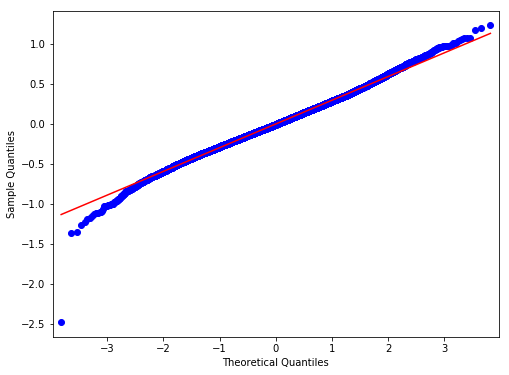

In [49]:
fig, axes = plt.subplots(figsize=(8,6))
statsmodels.graphics.gofplots.qqplot(reg2.resid, ax=axes, line='r')
plt.show()

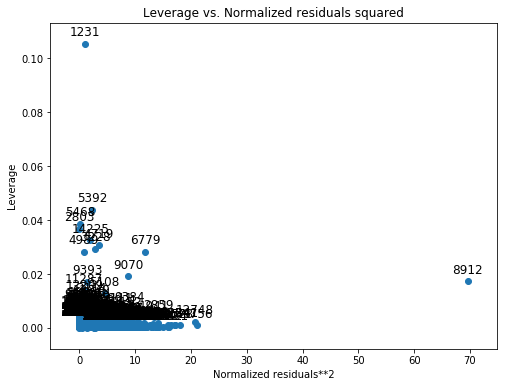

In [50]:
fig, ax = plt.subplots(figsize=(8,6))
statsmodels.graphics.regressionplots.plot_leverage_resid2(reg2, ax = ax)
plt.show()

등분산성을 만족하는 지 보겠습니다.

In [51]:
name = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test = sm.stats.het_breuschpagan(reg2.resid, reg2.model.exog)
statsmodels.compat.lzip(name, test)

[('Lagrange multiplier statistic', 701.2978633110841),
 ('p-value', 2.325436488910038e-142),
 ('f-value', 66.82025404851596),
 ('f p-value', 8.148224424176625e-147)]

등분산성도 만족 못하고 있습니다. 뭐지 레버리지 문제인가?

선형성을 만족하는 지 보겠습니다.

In [52]:
X = sm.add_constant(train[['sqft_living','long']])
reg3 = sm.OLS(price, X.astype(float)).fit()

In [53]:
name = ['t value', 'p value']
test = sm.stats.linear_harvey_collier(reg3)
statsmodels.compat.lzip(name, test)

[('t value', 1.8527328730138173), ('p value', 0.06394024366429764)]

determinant 행렬식을 구할 수 없을 때(역행렬을 구할 수 없다) 발생하는 오류입니다. 다중공선성으로 인해 발생 된 문제로 보입니다.

회귀진단
- 잔차의 정규성 ( Jarque-Bera test)
- 선형성(Linearity) - Harvey Collier mulitplier test
- 등분산성 - Breausch Pagan Godfrey test
- 독립성 - 더빈왓슨인데 글쎄...
- 영향테스트 - 레버리지 플랏이용?
- 다중공선성 검사

In [54]:
# fitted values (need a constant term for intercept)
model_fitted_y = reg2.fittedvalues

# model residuals
model_residuals = reg2.resid

# normalized residuals
model_norm_residuals = reg2.get_influence().resid_studentized_internal

# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = sp.sqrt(sp.absolute(model_norm_residuals))

# absolute residuals
model_abs_resid = sp.absolute(model_residuals)

# leverage, from statsmodels internals
model_leverage = reg2.get_influence().hat_matrix_diag

# cook's distance, from statsmodels internals
model_cooks = reg2.get_influence().cooks_distance[0]

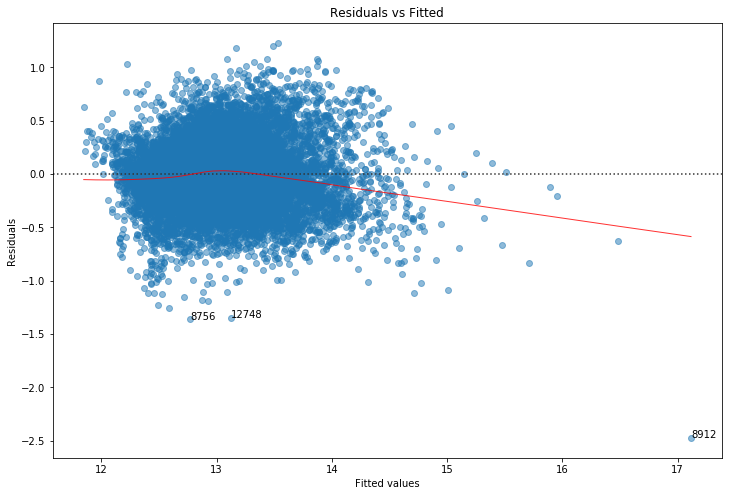

In [55]:
plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(8)
plot_lm_1.set_figwidth(12)

plot_lm_1.axes[0] = sns.residplot(model_fitted_y, 'price', pd.concat([train, price], axis=1),
                          lowess=True, 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')

# annotations
abs_resid = model_abs_resid.sort_values(ascending=False)
abs_resid_top_3 = abs_resid[:3]

for i in abs_resid_top_3.index:
    plot_lm_1.axes[0].annotate(i, 
                               xy=(model_fitted_y[i], 
                                   model_residuals[i]));

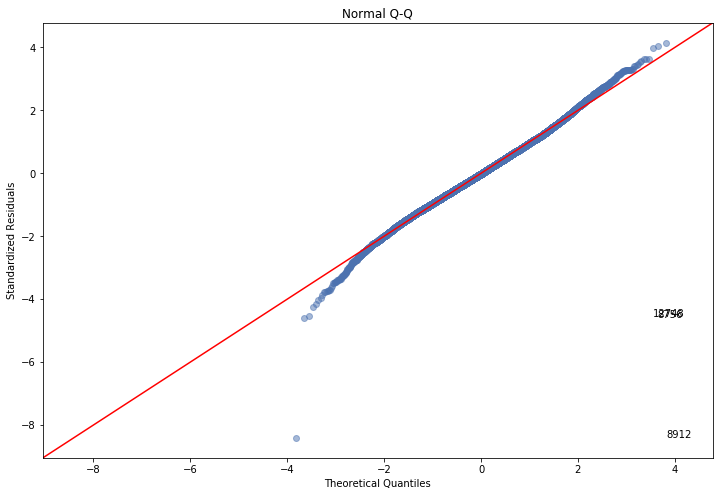

In [56]:
QQ = sm.ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)

plot_lm_2.set_figheight(8)
plot_lm_2.set_figwidth(12)

plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');

# annotations
abs_norm_resid = sp.flip(sp.argsort(sp.absolute(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]

for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i, 
                               xy=(sp.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]));

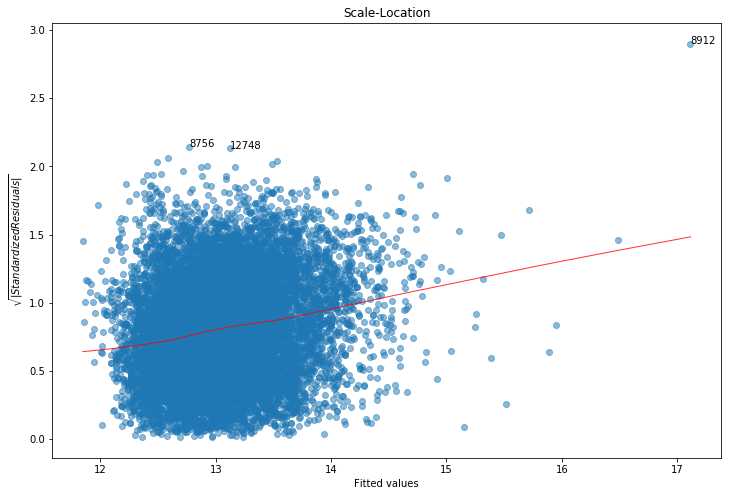

In [57]:
plot_lm_3 = plt.figure(3)
plot_lm_3.set_figheight(8)
plot_lm_3.set_figwidth(12)

plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5)
sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_3.axes[0].set_title('Scale-Location')
plot_lm_3.axes[0].set_xlabel('Fitted values')
plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

# annotations
abs_sq_norm_resid = sp.flip(sp.argsort(model_norm_residuals_abs_sqrt), 0)
abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]

for i in abs_norm_resid_top_3:
    plot_lm_3.axes[0].annotate(i, 
                               xy=(model_fitted_y[i], 
                                   model_norm_residuals_abs_sqrt[i]));

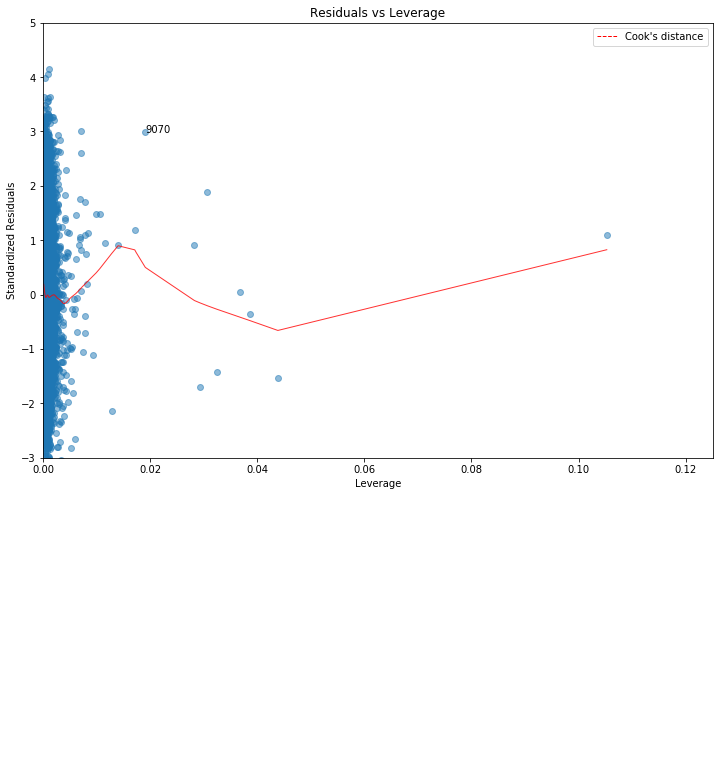

In [58]:

plot_lm_4 = plt.figure(4)
plot_lm_4.set_figheight(8)
plot_lm_4.set_figwidth(12)

plt.scatter(model_leverage, model_norm_residuals, alpha=0.5)
sns.regplot(model_leverage, model_norm_residuals, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_4.axes[0].set_xlim(0, 0.125)
plot_lm_4.axes[0].set_ylim(-3, 5)
plot_lm_4.axes[0].set_title('Residuals vs Leverage')
plot_lm_4.axes[0].set_xlabel('Leverage')
plot_lm_4.axes[0].set_ylabel('Standardized Residuals')

# annotations
leverage_top_3 = sp.flip(sp.argsort(model_cooks), 0)[:3]

for i in leverage_top_3:
    plot_lm_4.axes[0].annotate(i, 
                               xy=(model_leverage[i], 
                                   model_norm_residuals[i]))
    
# shenanigans for cook's distance contours
def graph(formula, x_range, label=None):
    x = x_range
    y = formula(x)
    plt.plot(x, y, label=label, lw=1, ls='--', color='red')

p = len(reg2.params) # number of model parameters

graph(lambda x: sp.sqrt((0.5 * p * (1 - x)) / x), 
      sp.linspace(0.001, 0.125, 50), 
      'Cook\'s distance') # 0.5 line
graph(lambda x: sp.sqrt((1 * p * (1 - x)) / x), 
      sp.linspace(0.001, 0.125, 50)) # 1 line
plt.legend(loc='upper right');

등분산성, 정규성, 독립성, 

이런 비슷한 성능의 모델을 평가하는 지표 중 RMSE로 성능을 비교해 보겠습니다.

## <a id='52'>Evalution</a>
모델을 평가하기 위해 예측하고, 예측의 지표로 RMSE를 확인합니다. Cross-validation을 통해 과적합을 방지하겠습니다.

In [59]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import KFold

from sklearn.metrics import mean_squared_error

In [60]:
n_splits = 5
rkf = KFold(n_splits=n_splits, shuffle=True, random_state=1028)

In [61]:
reg_mean_rmse = 0
reg2_mean_rmse = 0
ridge_reg_mean_rmse = 0
lasso_reg_mean_rmse = 0
elastic_reg_mean_rmse = 0


for trn_idx, val_idx in rkf.split(train):
    trn_X, trn_y = train.loc[trn_idx], price[trn_idx]
    val_X, val_y = train.loc[val_idx], price[val_idx]
    
    regr_pred = LinearRegression().fit(trn_X, trn_y).predict(val_X)
    regr2_pred = LinearRegression().fit(trn_X[result_pvalue], trn_y).predict(val_X[result_pvalue])
    regr3_pred = Ridge().fit(trn_X, trn_y).predict(val_X)
    regr4_pred = Lasso().fit(trn_X, trn_y).predict(val_X)
    regr5_pred = ElasticNet().fit(trn_X, trn_y).predict(val_X)
    
    reg_mean_rmse += sp.sqrt(mean_squared_error(sp.expm1(val_y), sp.expm1(regr_pred)))/n_splits
    reg2_mean_rmse += sp.sqrt(mean_squared_error(sp.expm1(val_y), sp.expm1(regr2_pred)))/n_splits
    ridge_reg_mean_rmse += sp.sqrt(mean_squared_error(sp.expm1(val_y), sp.expm1(regr3_pred)))/n_splits
    lasso_reg_mean_rmse += sp.sqrt(mean_squared_error(sp.expm1(val_y), sp.expm1(regr4_pred)))/n_splits
    elastic_reg_mean_rmse += sp.sqrt(mean_squared_error(sp.expm1(val_y), sp.expm1(regr5_pred)))/n_splits

print('Full Model RMSE : {0:0.2f}'.format(reg_mean_rmse))
print('Variable remove Model RMSE : {0:0.2f}'.format(reg2_mean_rmse))
print('Ridge Model RMSE : {0:0.2f}'.format(ridge_reg_mean_rmse))
print('Lasso Model RMSE : {0:0.2f}'.format(lasso_reg_mean_rmse))
print('Elastice Net Model RMSE : {0:0.2f}'.format(elastic_reg_mean_rmse))

Full Model RMSE : 186914.55
Variable remove Model RMSE : 288352.57
Ridge Model RMSE : 180424.77
Lasso Model RMSE : 295754.45
Elastice Net Model RMSE : 296146.50


ridge model이 가장 성능이 좋은 것을 볼 수 있습니다.

## <a id='53'>Submission</a>
